<font color='blue'> **03_MF-Setup_Pleasant_lake_LGR** </font> 

In [1]:
%%capture
import os ; import numpy as np ; import pandas as pd ;from scipy.interpolate import griddata ;import matplotlib.pyplot as plt ;
from matplotlib import patheffects ;import flopy ;import flopy.utils.binaryfile as bf ;from mfsetup import MF6model ; from pathlib import Path
from mfsetup.discretization import cellids_to_kij ;from gisutils import df2shp ;import mfexport ;from mfexport.utils import get_water_table
sim_ws   = Path("./03_MFSetup")       ;sim_ws.mkdir(exist_ok=True)
ref_data = Path('E:\\15_REPOS\\00_BETAMI\\bin\\MFSetup\\examples') 

In [2]:
%%capture
mm = MF6model(cfg= ref_data / 'pleasant_lgr_parent.yml') ; mm.setup_grid() 

In [3]:
print(mm.modelgrid); mm.inset['plsnt_lgr_inset'].modelgrid

xll:553400.0; yll:387800.0; rotation:0.0; crs:EPSG:3070; units:undefined; lenuni:0


75 row(s), 85 column(s)
delr: [40.00...40.00] undefined
delc: [40.00...40.00] undefined
CRS: EPSG:3070
length units: meters
xll: 554200.0; yll: 388800.0; rotation: 0
Bounds: (np.float64(554200.0), np.float64(557600.0), np.float64(388800.0), np.float64(391800.0))

In [4]:
%%capture
mm = MF6model.setup_from_yaml(ref_data / 'pleasant_lgr_parent.yml')

In [5]:
mm.cfg.keys()

dict_keys(['metadata', 'simulation', 'model', 'parent', 'postprocessing', 'setup_grid', 'dis', 'tdis', 'ic', 'npf', 'sto', 'rch', 'sfr', 'high_k_lakes', 'lak', 'mvr', 'chd', 'drn', 'ghb', 'riv', 'wel', 'oc', 'obs', 'ims', 'mfsetup_options', 'filename', 'maw', 'external_files', 'intermediate_data', 'grid'])

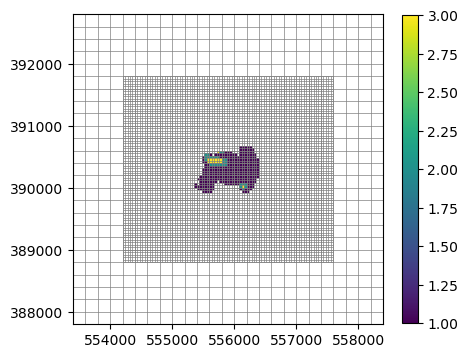

In [6]:
inset = mm.inset['plsnt_lgr_inset']  ; l, r, b, t = mm.modelgrid.extent  ; layer = 0
fig, ax = plt.subplots(figsize=(5, 5))
parent_mv = flopy.plot.PlotMapView(model=mm, ax=ax, layer=layer)  ; inset_mv = flopy.plot.PlotMapView(model=inset, ax=ax, layer=layer)
vconn = inset.lak.connectiondata.array[inset.lak.connectiondata.array['claktype'] == 'vertical']     ; k, i, j = cellids_to_kij(vconn['cellid'])
lakeconnections = np.zeros((inset.nrow, inset.ncol))                                                 ; lakeconnections[i, j] = np.array(k+1)
lakeconnections = np.ma.masked_array(lakeconnections, mask=lakeconnections == 0)                     ; qmi = inset_mv.plot_array(lakeconnections)
lcp = parent_mv.plot_grid(lw=0.5, ax=ax) ; lci = inset_mv.plot_grid(lw=0.5) ; ax.set_ylim(b, t)  ;ax.set_xlim(l, r) ; ax.set_aspect(1) ; plt.colorbar(qmi, shrink=0.8)

(190.0, 400.0)

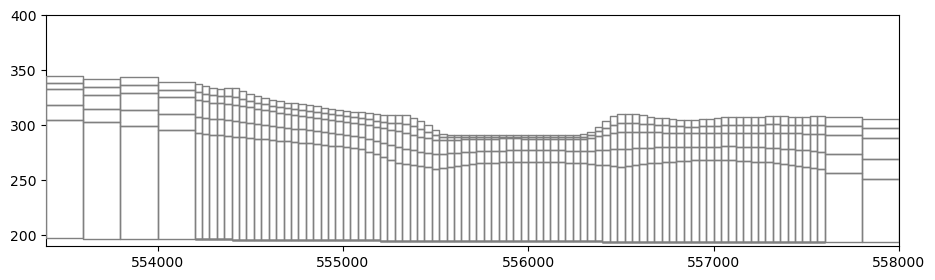

In [7]:
fig, ax = plt.subplots(figsize=(11, 3))  ; xs_line = [(553000, 390200), (558000, 390200)]
xs = flopy.plot.PlotCrossSection(model=mm,line={"line": xs_line}, ax=ax,geographic_coords=True)      ; lc = xs.plot_grid(zorder=4)
xs2 = flopy.plot.PlotCrossSection(model=inset,line={"line": xs_line}, ax=ax,geographic_coords=True)  ; lc = xs2.plot_grid(zorder=4) ; ax.set_ylim(190, 400)

In [8]:
%%capture
mm.write_input()

In [9]:
os.getcwd()

'E:\\15_REPOS\\00_BETAMI\\bin\\MFSetup\\examples\\pleasant_lgr'

In [10]:
mm.simulation.run_simulation(silent=True)

(True, [])

In [11]:
print('path01:', ref_data)                           ; ref_data2 = Path('E:\\15_REPOS\\00_BETAMI\\bin\\MFSetup\\examples\\pleasant_lgr') 

path01: E:\15_REPOS\00_BETAMI\bin\MFSetup\examples


In [12]:
tmr_parent_headsobj = bf.HeadFile(ref_data / 'data/pleasant/pleasant.hds')
lgr_parent_headsobj = bf.HeadFile('plsnt_lgr_parent.hds')        ; lgr_inset_headsobj = bf.HeadFile('plsnt_lgr_inset.hds')
kper = 12  
lgr_parent_hds = lgr_parent_headsobj.get_data(kstpkper=(0, kper)) ; lgr_inset_hds = lgr_inset_headsobj.get_data(kstpkper=(0, kper))
inset_wt = get_water_table(lgr_inset_hds, nodata=1e30)  ; parent_wt = get_water_table(lgr_parent_hds, nodata=1e30)
lake_results = pd.read_csv(ref_data2 /'lake1.obs.csv')  ; stage = lake_results['STAGE'][kper]  ; inset_wt[inset.lakarr[0] == 1] = stage

l, b, r, t = mm.modelgrid.bounds ; xi = np.arange(l, r, 40) ; yi = np.arange(b, t, 40)[::-1] ; Xi, Yi = np.meshgrid(xi, yi)

x = mm.modelgrid.xcellcenters[~parent_wt.mask]                    ; y = mm.modelgrid.ycellcenters[~parent_wt.mask]
x = np.append(x, inset.modelgrid.xcellcenters[~inset_wt.mask])    ; y = np.append(y, inset.modelgrid.ycellcenters[~inset_wt.mask])
z = parent_wt[~parent_wt.mask].data                               ; z = np.append(z, inset_wt[~inset_wt.mask].data)
results = griddata((x, y), z, (Xi, Yi))

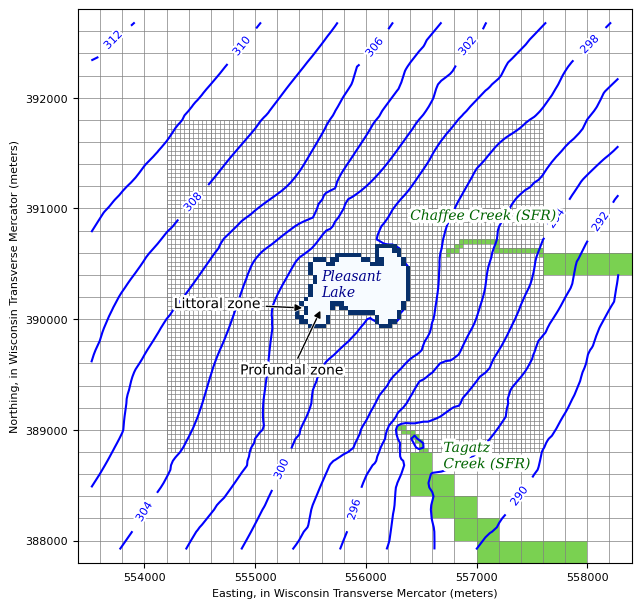

In [13]:
plt.rcParams['axes.labelsize'] = 8  ; plt.rcParams['xtick.labelsize'] = 8  ; plt.rcParams['ytick.labelsize'] = 8

layer = 0   ; fig, ax = plt.subplots(figsize=(6.5, 6.5))
parent_mv = flopy.plot.PlotMapView(model=mm, ax=ax, layer=layer)  ; inset_mv = flopy.plot.PlotMapView(model=inset, ax=ax, layer=layer)

inset_bcs = np.ma.masked_array(inset._isbc2d, mask=inset._isbc2d==0)  ; parent_bcs = np.ma.masked_array(mm._isbc2d, mask=mm._isbc2d==0)
parent_mv.plot_array(parent_bcs, vmin=0, vmax=5)   ; inset_mv.plot_array(inset_bcs, vmin=0, vmax=5)

conn = inset.lak.connectiondata.array ; k, i, j = cellids_to_kij(conn['cellid'])
bdlknc = np.zeros((inset.nlay, inset.nrow, inset.ncol)) ; bdlknc[k, i, j] = conn['bedleak'] ; bdlknc = np.max(bdlknc, axis=0)
bdlknc = np.ma.masked_array(bdlknc, mask=bdlknc == 0) ; inset_mv.plot_array(bdlknc, cmap='Blues', zorder=200)

levels = np.arange(290, 315, 2)                                     ; ctr = ax.contour(Xi, Yi, results, levels=levels, colors='b', zorder=10) ; 
labels = ax.clabel(ctr, inline=True, fontsize=8, inline_spacing=10) ; plt.setp(labels, path_effects=[patheffects.withStroke(linewidth=3, foreground="w")])

lcp = parent_mv.plot_grid(lw=0.5, ax=ax) ; lci = inset_mv.plot_grid(lw=0.5)
ax.set_ylim(b, t) ; ax.set_xlim(l, r) ; ax.set_aspect(1)
ax.set_ylabel('Northing, in Wisconsin Transverse Mercator (meters)') ; ax.set_xlabel('Easting, in Wisconsin Transverse Mercator (meters)')

ax.text(555600, 390450, 'Pleasant\nLake', ha='left', va='top', color='DarkBlue',fontsize=10, fontstyle='italic', family='Serif', zorder=202)
txt = ax.text(556400, 391000, 'Chaffee Creek (SFR)', ha='left', va='top', color='DarkGreen',fontsize=10, fontstyle='italic', family='Serif', zorder=20)
txt.set_path_effects([patheffects.withStroke(linewidth=5, foreground='w')])
txt = ax.text(556700, 388900, 'Tagatz\nCreek (SFR)', ha='left', va='top', color='DarkGreen',fontsize=10, fontstyle='italic', family='Serif', zorder=20)
txt.set_path_effects([patheffects.withStroke(linewidth=5, foreground='w')])

txt = ax.annotate("Littoral zone",xy=(555450, 390100), xycoords='data',xytext=(555050,390100), textcoords='data',ha='right',arrowprops=dict(arrowstyle="-|>",
connectionstyle="arc3", fc='k'),path_effects=[patheffects.withStroke(linewidth=4, foreground='w')],zorder=203)
txt.arrow_patch.set_path_effects([patheffects.Stroke(linewidth=2, foreground="w"),patheffects.Normal()])

txt = ax.annotate("Profundal zone",xy=(555600, 390100), xycoords='data',xytext=(555800,389500), textcoords='data',ha='right',arrowprops=dict(arrowstyle="-|>",
                  connectionstyle="arc3", fc='k'),path_effects=[patheffects.withStroke(linewidth=4, foreground='w')],zorder=203)
txt.arrow_patch.set_path_effects([patheffects.Stroke(linewidth=2, foreground="w"),patheffects.Normal()])

plt.tight_layout()

In [14]:
for model in mm, inset: mfexport.summarize(model, output_path=f'postproc/{model.name}/')
#for model in mm, inset: mfexport.summarize(model, output_path = sim_ws / f'{model.name}/')  ?

summarizing plsnt_lgr_parent input...
skipped, not implemented yet
skipped, not implemented yet
summarizing plsnt_lgr_inset input...
skipped, not implemented yet


#### References
Fienen, M. N., Haserodt, M. J., Leaf, A. T., and Westenbroek, S. M. (2022). Simulation of regional groundwater flow and groundwater/lake interactions in the central Sands, Wisconsin. U.S. Geological Survey Scientific Investigations Report 2022-5046. doi:10.3133/sir20225046

Langevin, C.D., Hughes, J.D., Banta, E.R., Niswonger, R.G., Panday, S., and Provost, A.M., 2017, Documentation for the MODFLOW 6 groundwater flow model: U.S. Geological Survey Techniques and Methods, book 6, chap. A55, 197 p., https://doi.org/ 10.3133/tm6A55.

Leaf, A.T. and Fienen, M.N. (2022) Modflow-setup: Robust automation of groundwater model construction. Front. Earth Sci. 10:903965. doi: 10.3389/feart.2022.903965

Mehl, S., Hill, M.C., and Leake, S.A., 2006, Comparison of local grid refinement methods for MODFLOW: Groundwater, v. 44, no. 6, p. 792–796, https://doi.org/10.1111/j.1745-6584.2006.00192.x

Westenbroek, S. M., Engott, J. A., Kelson, V. A., and Hunt, R. J. (2018). SWB Version 2.0—a soil-water-balance code for estimating net infiltration and other 1152 water-budget components. U.S. Geological Survey Techniques and Methods, book 6,
118. chap. A59. doi:10.3133/tm6A59

White, J. T., Hemmings, B., Fienen, M. N., and Knowling, M. J. (2021). Towards improved environmental modeling outcomes: Enabling low-cost access to high- 1157 dimensional, geostatistical-based decision-support analyses. Environ. Model. Softw.
139, 105022. doi:10.1016/j.envsoft.2021.105022

Wisconsin Department of Natural Resources (WDNR) (2021). Central Sands Lake study report: Findings and recommendations. Rep. Wis. State Legislature. 1162 doi:10.5281/zenodo.5708791